In [2]:
import sys
import os
sys.path.append(os.path.abspath('../'))

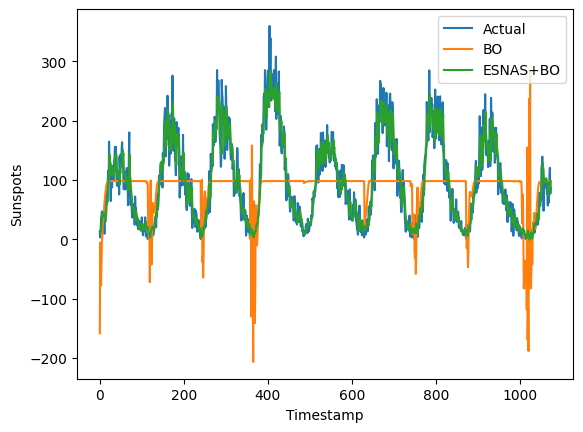

In [13]:

from NAS.error_metrics import r_squared, nrmse
from NAS.utils import runModel
from experiments.hybrid import nrmse_sunspots
from utils import readSavedExperiment
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def getDataSunspots():
    sunspots = pd.read_csv("../datasets/Sunspots.csv")
    data = sunspots.loc[:,"Monthly Mean Total Sunspot Number"].to_numpy()
    data = np.expand_dims(data, axis=1)

    trainLen = 1600
    valLen = 500
    testLen = 1074
    train_in = data[0:trainLen]
    train_out = data[0+1:trainLen+1]
    val_in = data[trainLen:trainLen+valLen]
    val_out = data[trainLen+1:trainLen+valLen+1]
    test_in = data[trainLen+valLen:trainLen+valLen+testLen]
    test_out = data[trainLen+valLen+1:trainLen+valLen+testLen+1]
    return train_in, train_out, val_in, val_out, test_in, test_out

_, _, _, _, testX, testY = getDataSunspots()
nrmseErrors = []
rSquaredValues = []
bo = readSavedExperiment('../backup_bo/sunspots/backup_{}.obj'.format(4))
hybrid = readSavedExperiment('../backup_hybrid/sunspots/backup_3.obj')
model = bo.bestModel
hybrid_model = hybrid.bestModel
preds = runModel(model, testX)
preds_hybrid = runModel(hybrid_model, testX)
plt.plot(testY)
plt.plot(preds)
plt.plot(preds_hybrid)
plt.xlabel("Timestamp")
plt.ylabel("Sunspots")
plt.legend(['Actual', 'BO', 'ESNAS+BO'], loc='upper right')

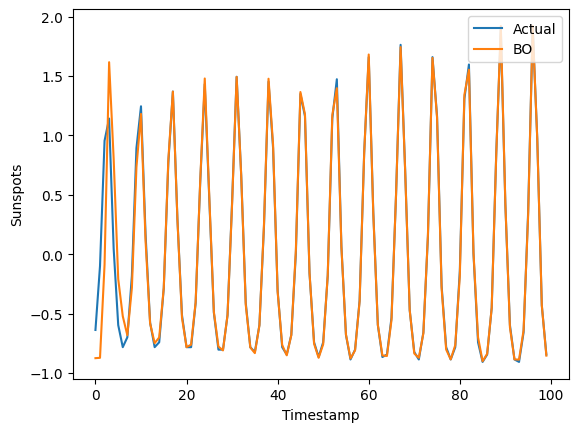

In [15]:
def getDataLaser():
    sunspots = pd.read_csv("../data/santafelaser.csv")
    data = np.array(sunspots)
    data = data.reshape((data.shape[0],1))
    data = data[:3801,:]
    from scipy import stats
    data = stats.zscore(data)

    trainLen = 2000
    valLen = 100
    testLen = 100
    train_in = data[0:trainLen]
    train_out = data[0+1:trainLen+1]
    val_in = data[trainLen:trainLen+valLen]
    val_out = data[trainLen+1:trainLen+valLen+1]
    test_in = data[trainLen+valLen:trainLen+valLen+testLen]
    test_out = data[trainLen+valLen+1:trainLen+valLen+testLen+1]
    return train_in, train_out, val_in, val_out, test_in, test_out

_, _, testX, testY, _, _ = getDataLaser()
nrmseErrors = []
rSquaredValues = []
bo = readSavedExperiment('../backup_bo/laser/backup_{}.obj'.format(4))
# hybrid = readSavedExperiment('../backup_hybrid/sunspots/backup_3.obj')
model = bo.bestModel
# hybrid_model = hybrid.bestModel
preds = runModel(model, testX)
# preds_hybrid = runModel(hybrid_model, testX)
plt.plot(testY)
plt.plot(preds)
# plt.plot(preds_hybrid)
plt.xlabel("Timestamp")
plt.ylabel("Sunspots")
plt.legend(['Actual', 'BO'], loc='upper right')

In [19]:
from NAS.error_metrics import r_squared, nrmse

r_squared(testY, preds)

0.9615580236805329

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_esn_architecture(architecture):
    lastNode = len(architecture['nodes']) - 1
    architecture['nodes'].append({'type': 'Output'})
    architecture['edges'].append([lastNode, lastNode+1])
    G = nx.DiGraph()
    
    # Add nodes
    for i, node in enumerate(architecture['nodes']):
        G.add_node(i, **node)
    
    G.add_edges_from(architecture['edges'])
    
    # Compute node levels (x-coordinates)
    levels = {}
    def dfs(node, level):
        if node not in levels:
            levels[node] = level
            for neighbor in G.neighbors(node):
                dfs(neighbor, level + 1)
    
    # Start DFS from input nodes (nodes with in_degree 0)
    input_nodes = [node for node in G.nodes() if G.in_degree(node) == 0]
    for input_node in input_nodes:
        dfs(input_node, 0)
    
    # Compute node positions
    pos = {}
    level_counts = {}
    for node, level in levels.items():
        if level not in level_counts:
            level_counts[level] = 0
        y = level_counts[level]
        level_counts[level] += 1
        pos[node] = (level, -y)  # Negative y to have top-to-bottom layout
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
    
    # Draw edges with arrows
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, 
                           arrowsize=20, arrowstyle='wedge', connectionstyle='arc3,rad=0')
    
    # Add labels (only node type)
    labels = {i: data['type'] for i, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight="bold")
    
    # Set title and remove axis
    plt.title("Echo State Network Architecture", fontsize=16)
    plt.axis('off')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [20]:
from NAS.ESN_NAS import ESN_NAS
from NAS.ESN_BO import ESN_BO
from NAS.error_metrics import nrmse, r_squared
from utils import readSavedExperiment
import numpy as np

def findBestGaArchitecture(ga: ESN_NAS):
    errors = [errors[0] for errors in ga.fitnesses]
    gaBestError = min(errors)
    gaBestErrorIndex = errors.index(gaBestError)
    gaBestModel = ga.architectures[gaBestErrorIndex]
    return gaBestModel, gaBestError

def findBestGasArchitecture(gas: list[ESN_NAS]):
    bestError = np.inf
    bestArchitecture = None
    for ga in gas:
        architecture, error = findBestGaArchitecture(ga)
        if error<bestError:
            bestArchitecture = architecture
    return bestArchitecture


<Figure size 500x500 with 0 Axes>

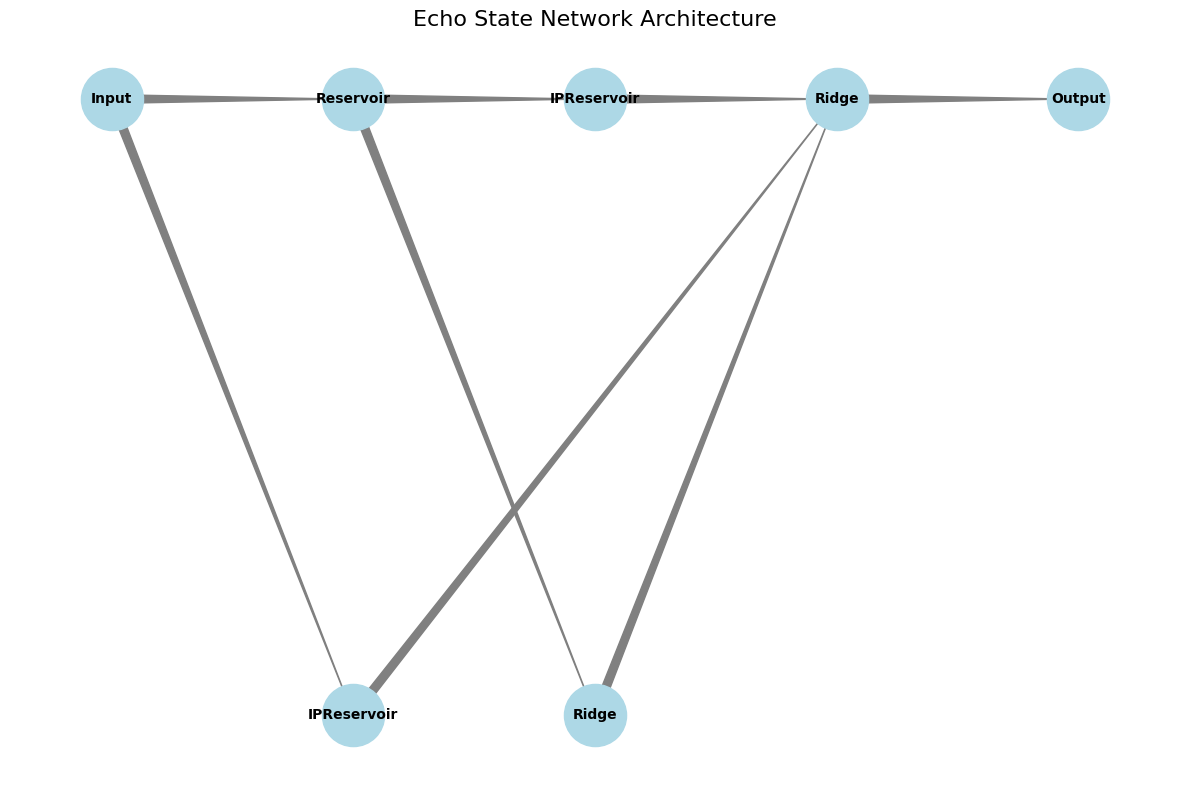

In [15]:
gas = [readSavedExperiment(f'../backup_50/mgs/backup_{i}.obj') for i in range(5)]
architecture = findBestGasArchitecture(gas)
visualize_esn_architecture(architecture)

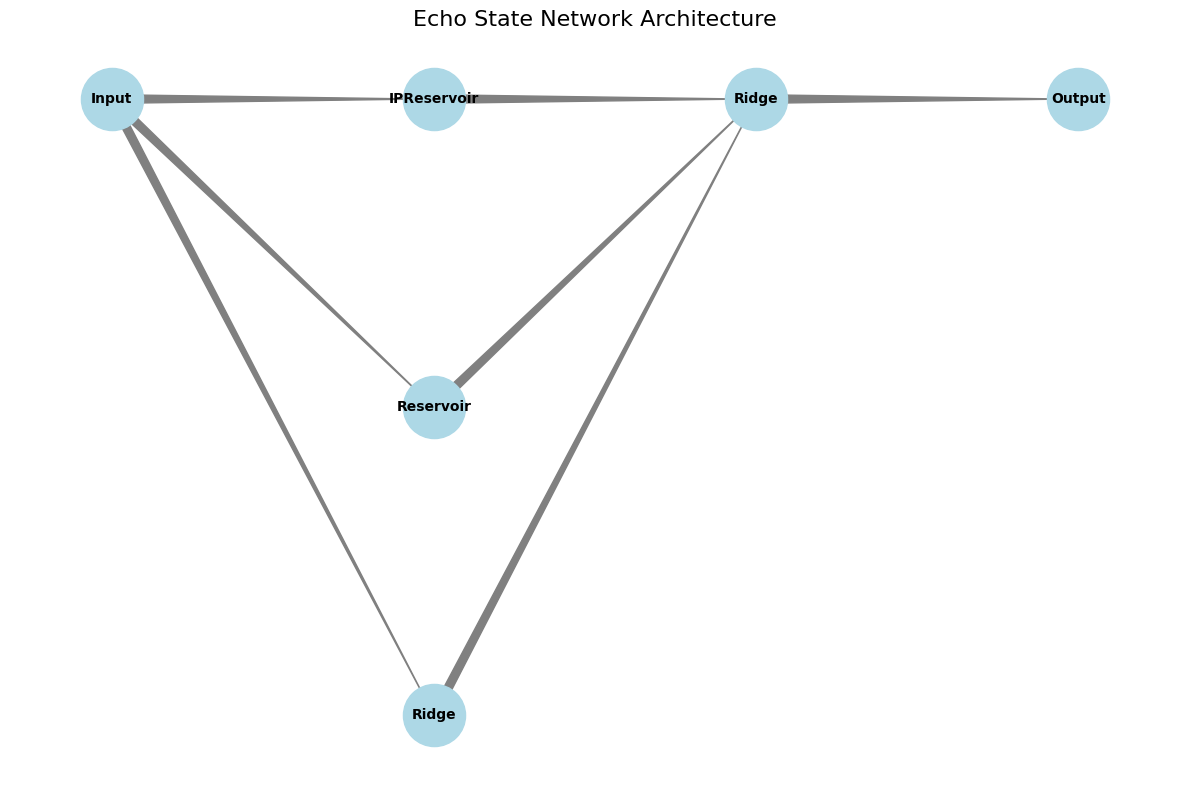

In [61]:
gas = [readSavedExperiment(f'../backup_50/dde/backup_{i}.obj') for i in range(5)]
architecture = findBestGasArchitecture(gas)
visualize_esn_architecture(architecture)

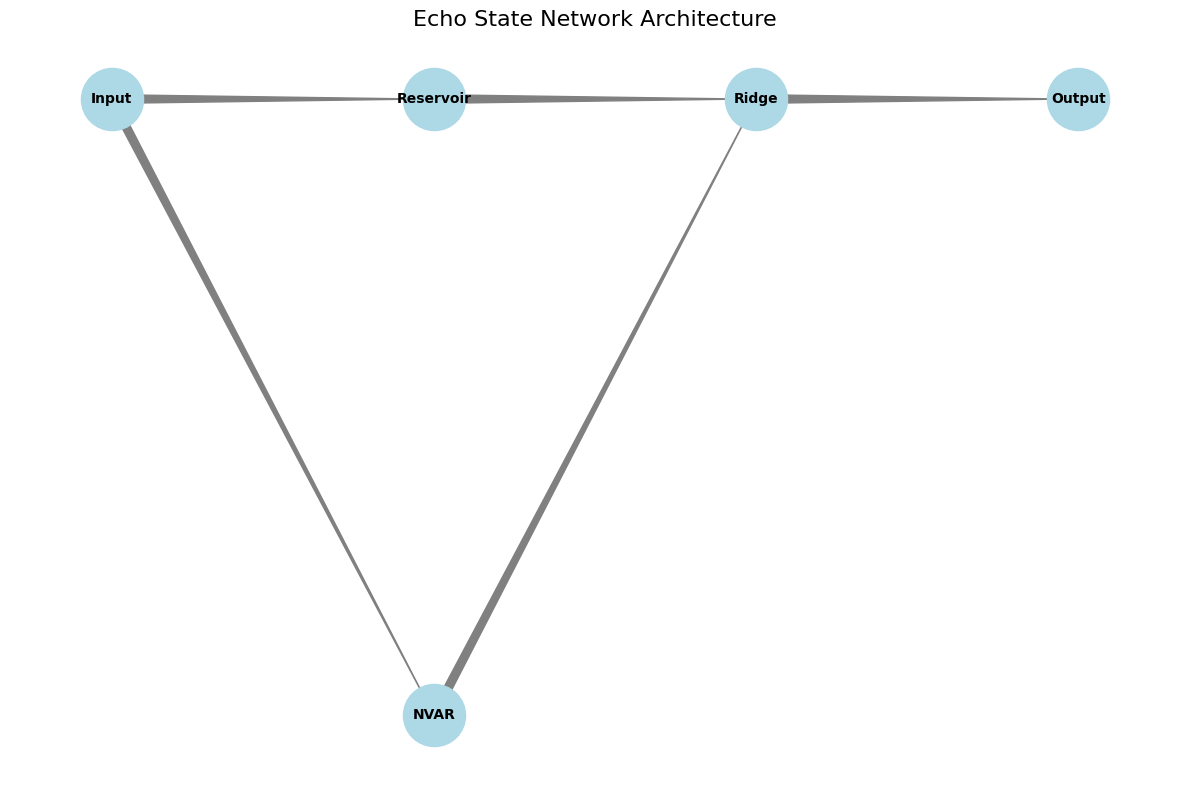

In [62]:
gas = [readSavedExperiment(f'../backup_50/laser/backup_{i}.obj') for i in range(5)]
architecture = findBestGasArchitecture(gas)
visualize_esn_architecture(architecture)

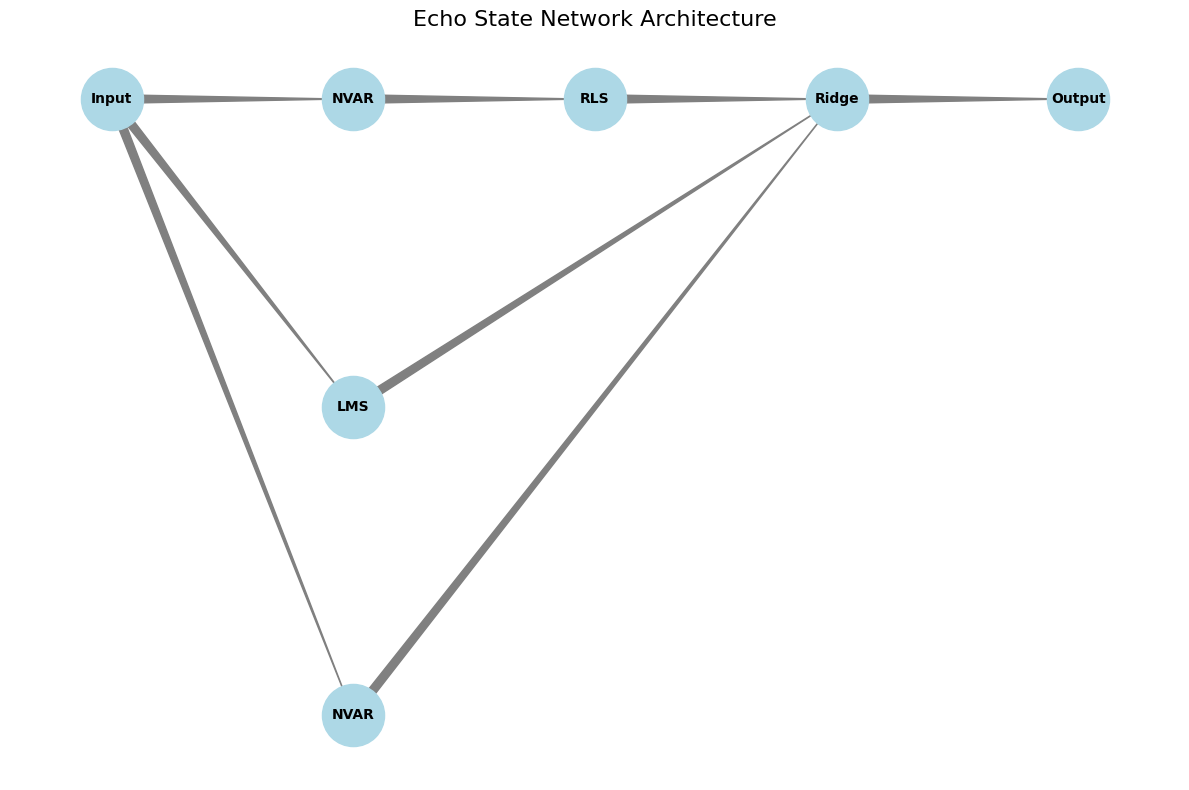

In [63]:
gas = [readSavedExperiment(f'../backup_50/lorenz/backup_{i}.obj') for i in range(5)]
architecture = findBestGasArchitecture(gas)
visualize_esn_architecture(architecture)

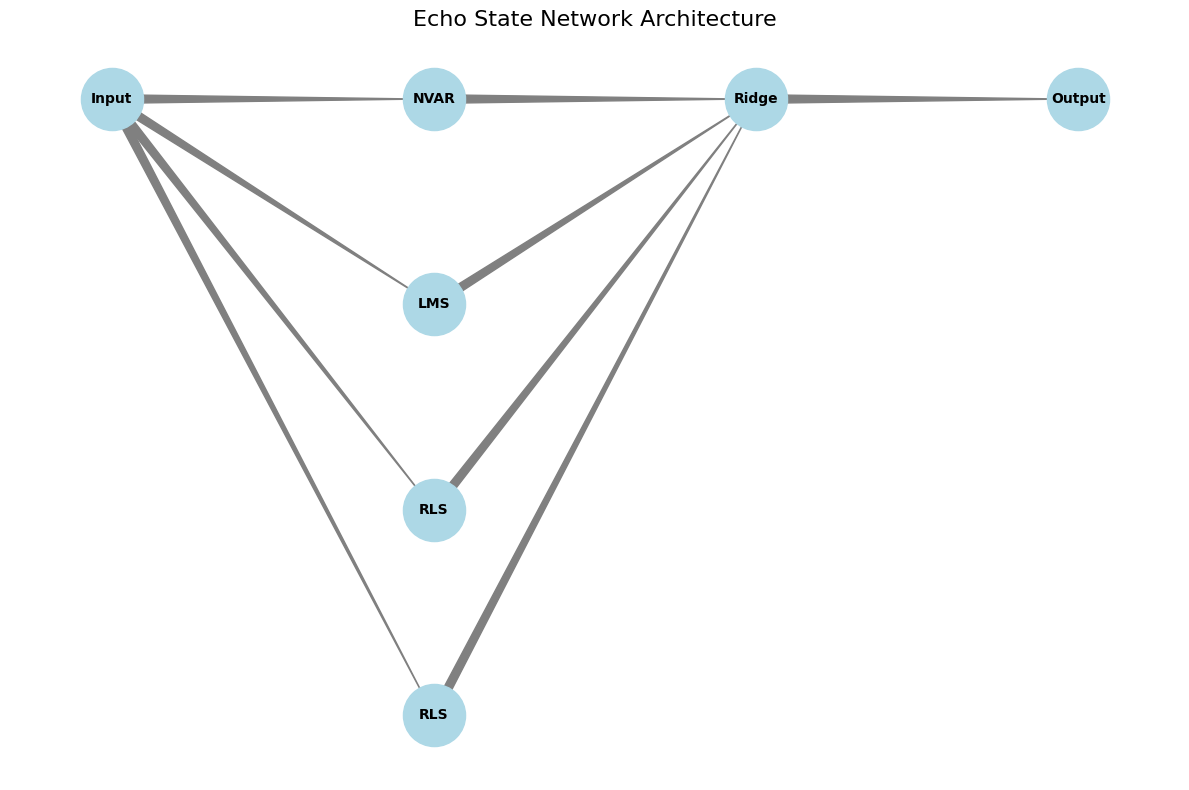

In [64]:
gas = [readSavedExperiment(f'../backup_50/water/backup_{i}.obj') for i in range(5)]
architecture = findBestGasArchitecture(gas)
visualize_esn_architecture(architecture)

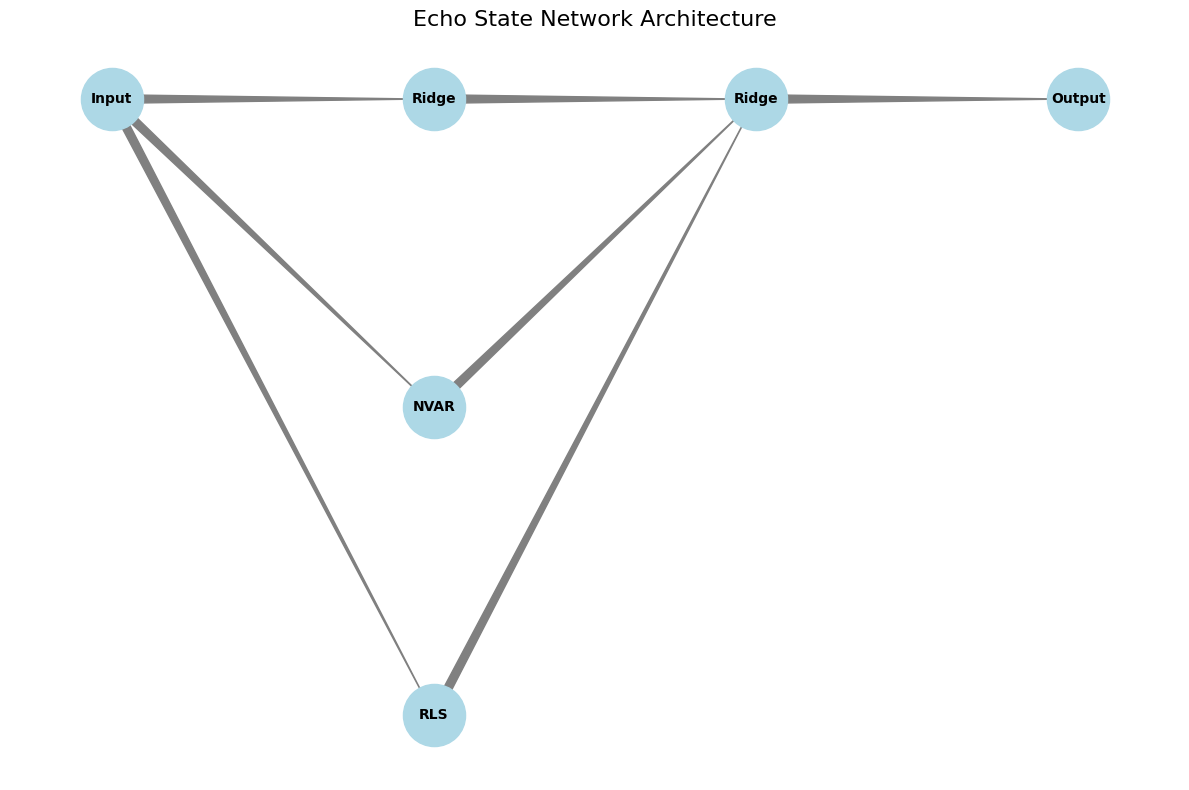

In [65]:
gas = [readSavedExperiment(f'../backup_50/sunspots/backup_{i}.obj') for i in range(5)]
architecture = findBestGasArchitecture(gas)
visualize_esn_architecture(architecture)

In [44]:
def plotConvergences(dataset, title):
    gas: list[ESN_NAS] = [readSavedExperiment(f'../backup_50/{dataset}/backup_{i}.obj') for i in range(5)]
    bos: list[ESN_BO] = [readSavedExperiment(f'../backup_hybrid/{dataset}/backup_{i}.obj') for i in range(5)]
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    for idx, ga in enumerate(gas):
        allNrmse = [error[0] for error in ga.fitnesses]
        nrmseFitnesses = []
        fitnessIndexStart = 0
        for i in range(ga.generations+1):
            generationEndIndex = fitnessIndexStart + ga.populationSize + 49 if i in ga.modelGenerationIndices and i>0 else fitnessIndexStart + ga.populationSize
            generationNrmses = allNrmse[fitnessIndexStart:generationEndIndex]
            fitnessIndexStart = generationEndIndex
            generationBestNrmse = min(generationNrmses) if len(generationNrmses)>0 else min(nrmseFitnesses)
            bestNrmse = min([generationBestNrmse, min(nrmseFitnesses)]) if len(nrmseFitnesses)>0 else generationBestNrmse
            nrmseFitnesses.append(bestNrmse)

        bo = bos[idx]
        allNrmseBO = [error[0] for error in bo.performances]
        formattedBONrmse = []
        for i in range(50):
            formattedBONrmse.append(min(allNrmseBO[i*50:(i+1)*50]))
        minBoFitness = formattedBONrmse[0]
        boFitnesses = []
        for fitness in formattedBONrmse:
            if fitness<minBoFitness:
                minBoFitness = fitness
            boFitnesses.append(minBoFitness)
        plt.plot(nrmseFitnesses, 'b-', color=colors[idx])
        plt.plot(range(len(nrmseFitnesses), len(nrmseFitnesses) + len(boFitnesses)), boFitnesses, 'b--', color=colors[idx])
    plt.title(title)
    plt.xlabel("Generation")
    plt.ylabel("NRMSE")
    plt.show()

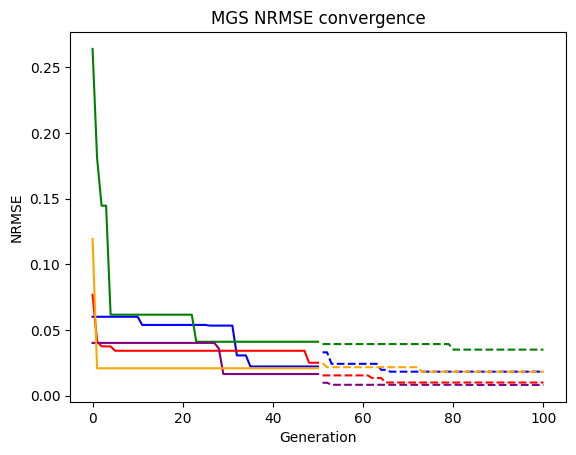

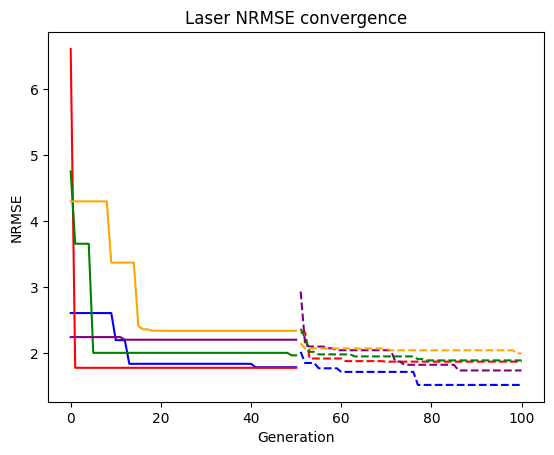

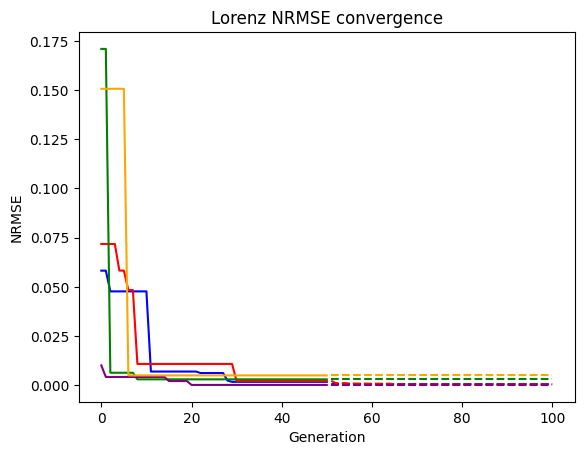

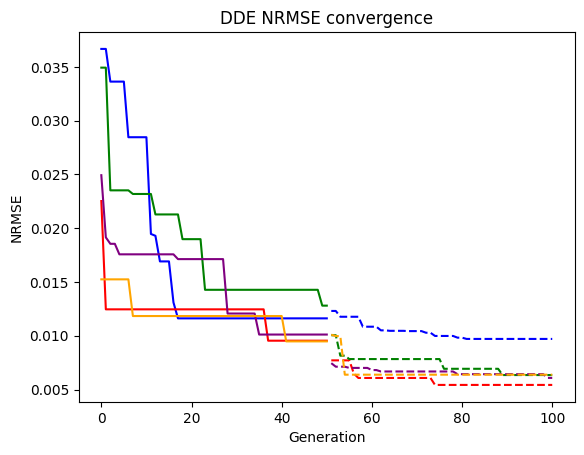

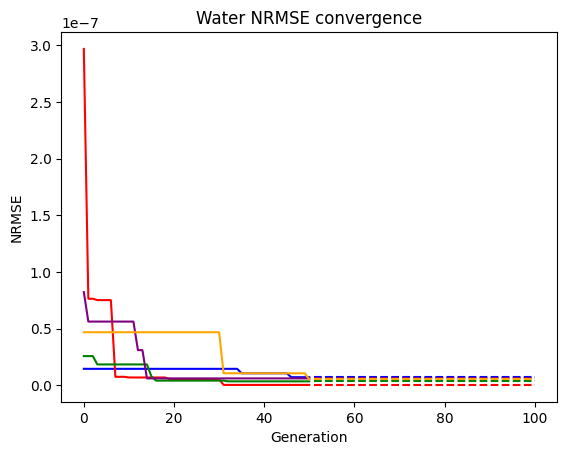

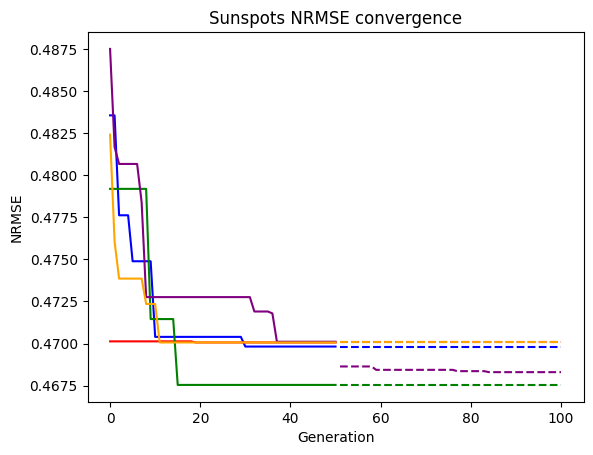

In [45]:
gas = [readSavedExperiment(f'../backup_50/mgs/backup_{i}.obj') for i in range(5)]
plotConvergences('mgs', "MGS NRMSE convergence")

gas = [readSavedExperiment(f'../backup_50/laser/backup_{i}.obj') for i in range(5)]
plotConvergences('laser', "Laser NRMSE convergence")

gas = [readSavedExperiment(f'../backup_50/lorenz/backup_{i}.obj') for i in range(5)]
plotConvergences('lorenz', "Lorenz NRMSE convergence")

gas = [readSavedExperiment(f'../backup_50/dde/backup_{i}.obj') for i in range(5)]
plotConvergences('dde', "DDE NRMSE convergence")

gas = [readSavedExperiment(f'../backup_50/water/backup_{i}.obj') for i in range(5)]
plotConvergences('water', "Water NRMSE convergence")

gas = [readSavedExperiment(f'../backup_50/sunspots/backup_{i}.obj') for i in range(5)]
plotConvergences('sunspots', "Sunspots NRMSE convergence")